# Dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
import xrft
from cdo import Cdo
# cdo = Cdo(tempdir='/network/aopp/chaos/pred/leach/.cdo_temp_files')
# uncomment the below if you want to clean up the temporary directory
# cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import regionmask
import xskillscore as xs
import pandas as pd
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import shutil
import gzip
import warnings

sys.path.append('/home/l/leach/Downloads/')
import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

## get FaIR
from fair import *

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

%matplotlib inline

In [2]:
import dask
from dask.distributed import Client, LocalCluster

def setUpCluster(
    n_workers: int, low_workers: int, high_workers: int, memory_limit: int
):
    dask.config.set({"temporary_directory": "/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/tmp/"})
    dask.config.set({"array.slicing.split_large_chunks": True})
    dask.config.set({"distributed.worker.memory.spill": 0.8})
    dask.config.set({"distributed.worker.use_file_locking": True})
    # DASK CLUSTER SET UP
    cluster = LocalCluster(
        n_workers=n_workers,
        dashboard_address="localhost:14286",
        memory_limit=f"{memory_limit} GiB",
        threads_per_worker=2,
    )
    cluster.adapt(minimum=low_workers, maximum=high_workers)

    print(f"dashboard : {cluster.dashboard_link}")
    client = Client(cluster)

    return cluster, client

In [3]:
## set up dask
cluster, client = setUpCluster(n_workers= 6, low_workers= 4, high_workers=10, memory_limit=3)

distributed.diskutils - INFO - Found stale lock file and directory '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/tmp/dask-worker-space/worker-v1fwuavg', purging


dashboard : http://127.0.0.1:14286/status


# Description
This notebook starts to look into some track / Lagrangian frame analysis of storm Eunice in ERA5 + the forecast experiments.

# General functions
A few preprocessing functions that are used more broadly.

In [4]:
# functions to convert accumulated variables to conventional ones

## accumulated variables & scaling factors
accumulated_vars = {'tp':60 * 60 * 24 * 1e3,'ttr':1,'tsr':1,'str':1,'ssr':1,'e':1}
accumulated_var_newunits = {'tp':'mm day$^{-1}$','ttr':'W m$^{-2}$','tsr':'W m$^{-2}$','str':'W m$^{-2}$','ssr':'W m$^{-2}$','e':'m s$^{-1}$'}

## definition to convert accumulated variables to instantaneous:
def accum2rate(ds):
    ds = ds.copy()
    oindex = ds.time
    inidate = pd.to_datetime(oindex[0].values)
    
    ds = ds.diff('time') / ( ds.time.diff('time').astype(float) / 1e9 )
    ds = ds.reindex(time=oindex)
    return ds[1:]

In [5]:
# main preprocessing function

def preproc_ds(ds):
    
    ds = ds.copy().squeeze()
    
    fname = ds.encoding['source'].split('/')[-1].split('.')[0]
    
    expver = fname.split('_')[0]
    ds = ds.expand_dims({'experiment':[expver]})
    
    # set up aux data
    inidate = pd.to_datetime(ds.time[0].values)
    
    # expand dimensions to include extra info
    if not 'hDate' in ds:
        ds = ds.expand_dims({'inidate':[inidate]})
        
    if not 'number' in ds:
        ds = ds.expand_dims({'number':[0]})
        
    # put time dimension at front
    ds = ds.transpose('time',...)
    
    # convert accumulated variables into instantaneous
    for var,sf in accumulated_vars.items():
        if var in ds.keys():
            ds[var][1:] = accum2rate(ds[var]) * sf
            # set first value to equal zero [since it should be zero... but isn't always]
            ds[var][0] = 0
            ds[var].attrs['units'] = accumulated_var_newunits[var]
            
    return ds

In [6]:
# need a couple more steps for preprocessing the m-climate

def preproc_mclim(ds):
    
    ds = ds.copy().squeeze()
    
    ds = preproc_ds(ds)
    
    # create index of hours from initialisation
    ds_hours = ((ds.time-ds.time.isel(time=0))/1e9/3600).astype(int)
    # change time coord to hours coord + rename
    ds = ds.assign_coords(time=ds_hours).rename(dict(time='hour'))
    
    return ds

In [7]:
def lagrangian_frame(ds):
    ds = ds.squeeze()
    ds = ds.assign_coords(latitude=ds.latitude-ds.centroid_lat,longitude=ds.longitude-ds.centroid_lon)
    ds = ds.rename(latitude='storm_lat',longitude='storm_lon')
    ds = ds.sel(storm_lon=slice(-10,10),storm_lat=slice(10,-10))
    return ds

# Import data

In [8]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

(45.0, 65.0)

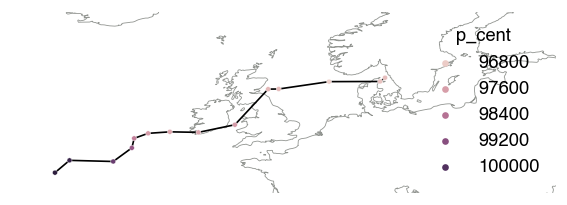

In [9]:
fig,ax = plt.subplots(subplot_kw=dict(projection=crs.PlateCarree()))
sn.lineplot(data=ERA5_eunice_track,x='long',y='lat',color='k')
sn.scatterplot(data=ERA5_eunice_track,x='long',y='lat',hue='p_cent',zorder=10)
ax.coastlines(color='xkcd:grey',lw=0.5)
ax.axis('off')
ax.set_xlim(-30,30)
ax.set_ylim(45,65)

In [10]:
ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

In [11]:
ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(lagrangian_frame)

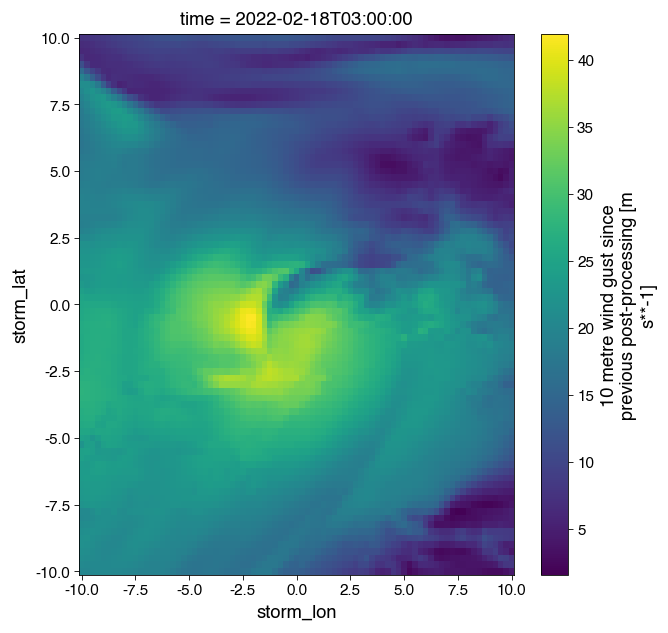

In [12]:
ERA5_eunice_stormframe.isel(time=6).fg10.plot()

## Get experimental data too

In [13]:
def import_medr_tracks(fpath):
    
    df = pd.read_hdf(fpath)
    
    fpath_split = fpath.split('/')
    exp = fpath_split[-5]
    ftype = fpath_split[-2]
    fname = fpath_split[-1]
    
    
    if ftype == 'pf':
        expid,inidate,mem = fname.split('_')
        mem = int(mem.split('m')[-1].split('.')[0])
    elif ftype == 'cf':
        expid,inidate = fname.split('_')
        inidate = inidate.split('.')[0]
        mem = 0
    
    df['expid'] = expid
    df['experiment'] = exp
    df['inidate'] = pd.to_datetime(inidate)
    df['number'] = mem
    
    return df

In [14]:
ens_fpaths = glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/*/*.h5')
exp_fpaths = glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/EXP/*/EU025/sfc/*/*.h5')

distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing


In [15]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks,[x for x in ens_fpaths+exp_fpaths if x.split('.')[0][-2:]!='ct'])

P1.close()

ifs_tracks = pd.concat(ifs_tracks)

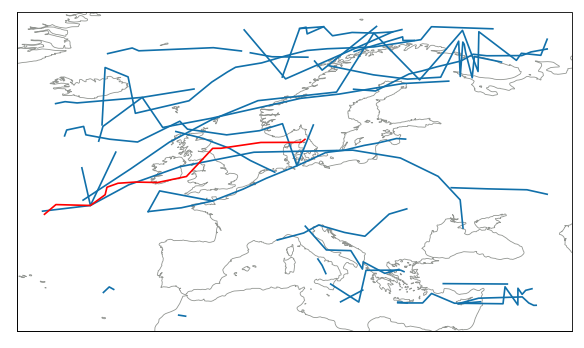

In [16]:
g=sn.relplot(data=ifs_tracks.query('inidate=="2022-02-10" & experiment=="ENS" & number==10'),x='long',y='lat',size='uid',sizes=(1,1),kind='line',legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())))

sn.lineplot(data=ERA5_eunice_track,x='long',y='lat',legend=False,color='r')

g.axes[0,0].coastlines(color='xkcd:grey',lw=0.5)

In [17]:
ifs_tracks_filter = ifs_tracks.groupby(['uid','inidate','experiment','number']).agg(dict(date = min, time = np.ptp, dDist = sum, long = min, lat = min, p_cent = min))
ifs_tracks_filter -= ERA5_eunice_track.groupby('uid').agg(dict(date = min, time = np.ptp, dDist = sum, long = min, lat = min, p_cent = min)).iloc[0]

Very basic selection criteria to start off with here:

In [18]:
ifs_tracks_filtered = ifs_tracks_filter.loc[(ifs_tracks_filter.date.dt.total_seconds().abs()<(12*60*60))&(ifs_tracks_filter.time>=-0.75)&(ifs_tracks_filter.dDist>-700)&(ifs_tracks_filter.long.abs()<5)&(ifs_tracks_filter.lat.abs()<5)&(ifs_tracks_filter.p_cent<1000)]

In [19]:
ifs_eunice_list = ifs_tracks.set_index(['uid','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

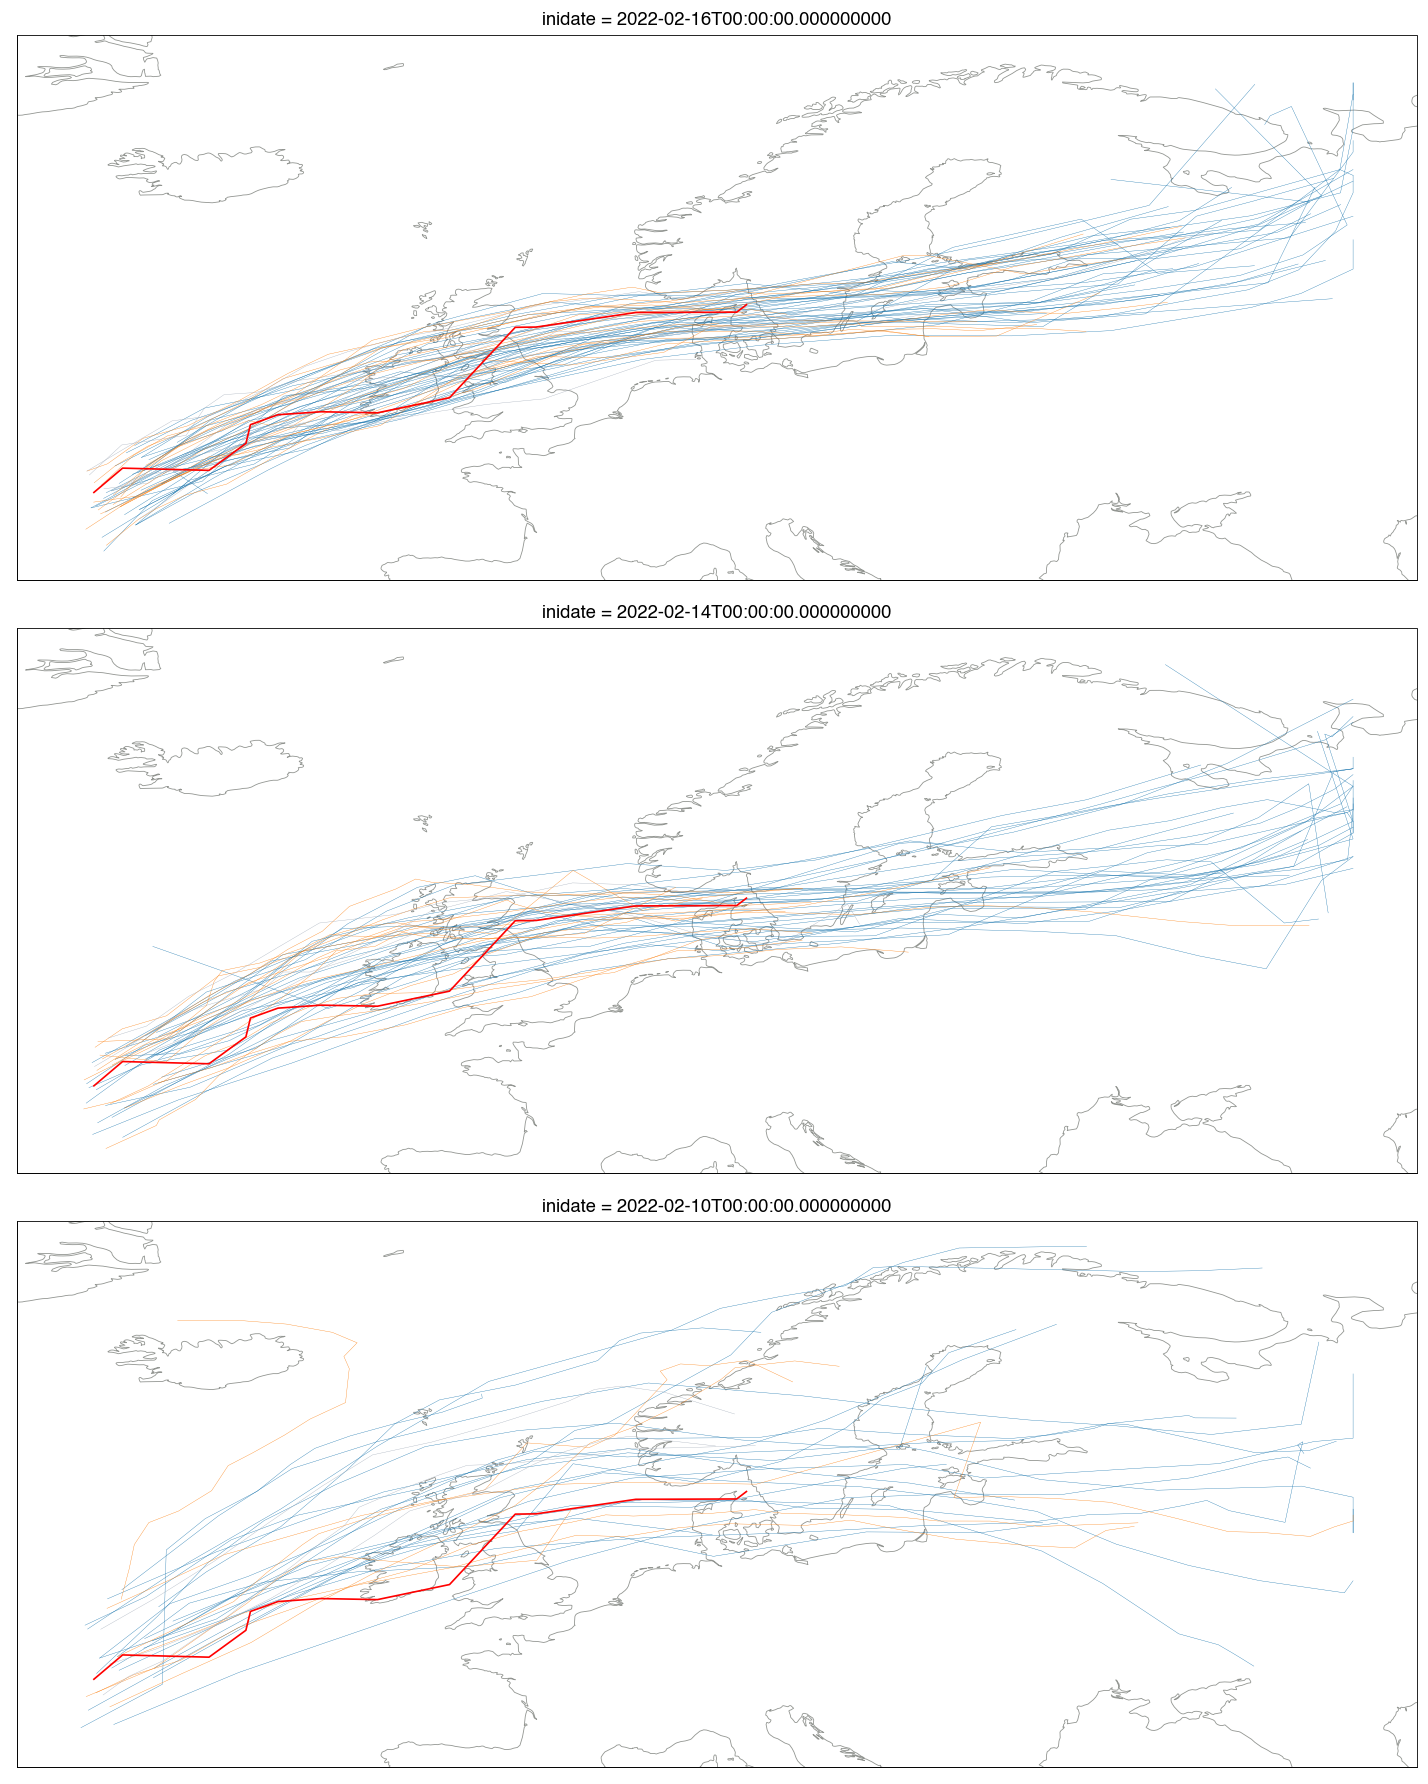

In [20]:
g=sn.relplot(data=ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])],x='long',y='lat',row='inidate',hue='experiment',size='number',sort=False,sizes=(0.2,0.2),kind='line',legend=False,estimator=None,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())),aspect=3)

[sn.lineplot(data=ERA5_eunice_track,x='long',y='lat',legend=False,color='r',ax=a) for a in g.axes.flatten()]
[a.coastlines(color='xkcd:grey',lw=0.5) for a in g.axes.flatten()];

In [21]:
def get_stormframe_fields(track_df):
    
    exp = track_df.experiment.unique()[0]
    number = track_df.number.unique()[0]
    inidate = pd.to_datetime(track_df.inidate.unique()[0]).strftime('%Y-%m-%d')
    
    if exp in ['incr','pi']:
        exp = 'EXP/'+exp
    if number == 0:
        ftype = 'cf'
    else:
        ftype = 'pf'
        
    ds_path = glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/{}/EU025/sfc/{}/*_{}.nc'.format(exp,ftype,inidate))[0]
    
    ds = xr.open_dataset(ds_path)
    if ftype=='pf':
        ds = ds.sel(number=number)
    time_intersection = sorted(list(set(ds.time.values).intersection(track_df.date.values)))
    ds = ds.sel(time = time_intersection)
    track_df = track_df.loc[track_df.date.isin(time_intersection)]
    ds['centroid_lon'] = ('time',(track_df.long*4).round()/4)
    ds['centroid_lat'] = ('time',(track_df.lat*4).round()/4)
    
    return ds.groupby('time').apply(lagrangian_frame)

In [22]:
testrack = get_stormframe_fields(ifs_eunice_list.query('inidate=="2022-02-14" & experiment=="incr" & number==1'))

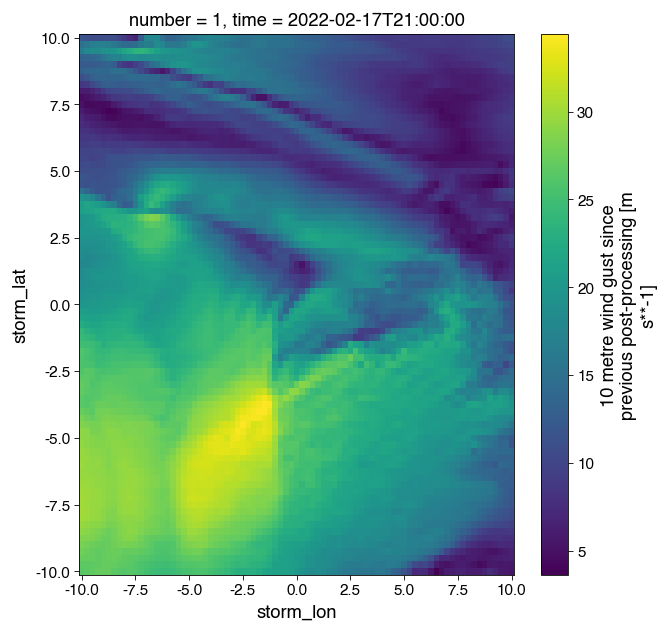

In [23]:
testrack.isel(time=5).fg10.plot()

In [24]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','uid']).agg(dict(p_cent=min,dDist=sum,date=min)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - pd.to_datetime('2022-02-18 12')).dt.total_seconds()

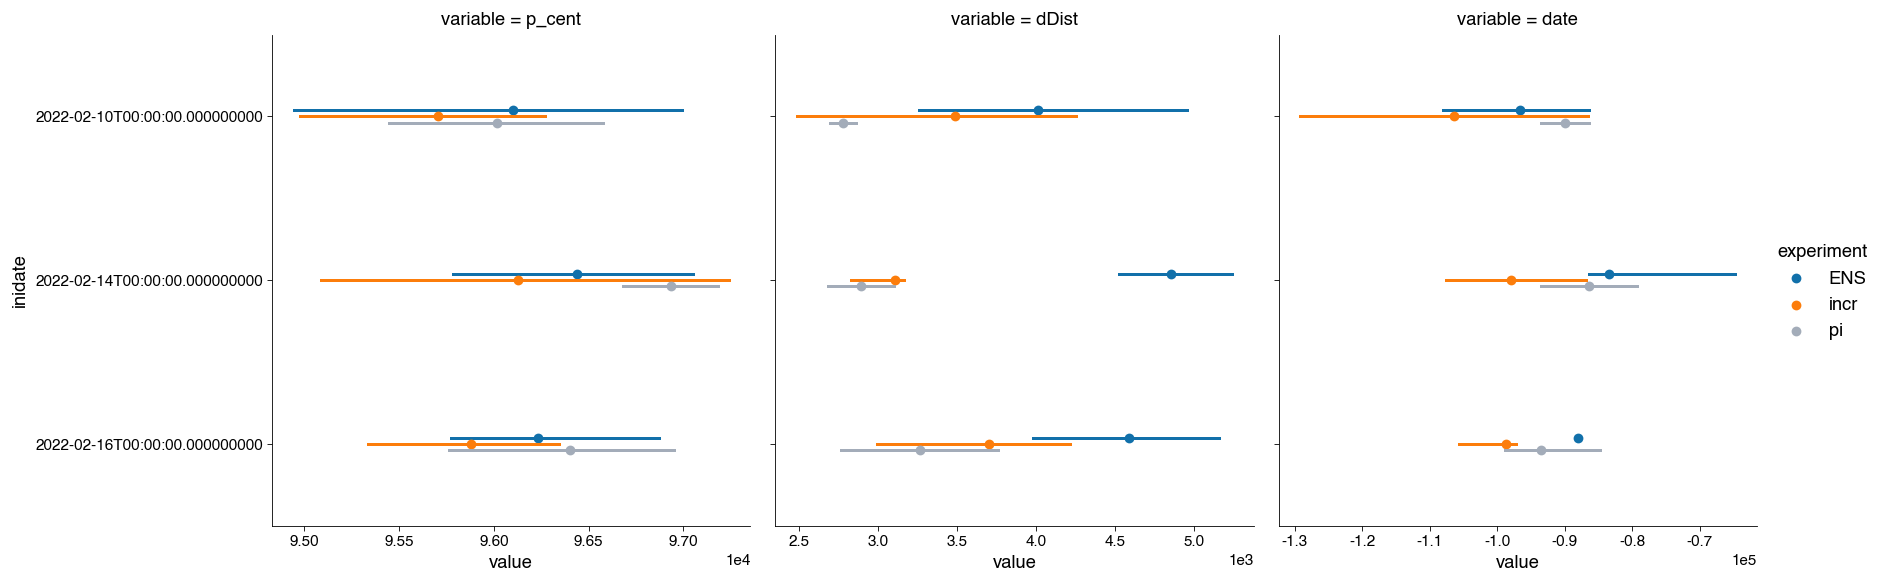

In [25]:
sn.catplot(data=ifs_eunice_list_stats.set_index(['experiment','inidate']).drop(['uid','number'],axis=1).stack().astype(float).reset_index().rename({'level_2':'variable',0:'value'},axis=1),
           x='value',col='variable',y='inidate',hue='experiment',kind='point',join=False,dodge=True,errorbar=('pi',66),n_boot=10000,sharex=False)

## Testing TempestExtremes implementation
Seems pretty good once tuned - and arguably more interpretable (since less complex) than CycloneTracking.

In [26]:
def import_medr_tracks_TE(fpath):
    
    df = pd.read_csv(fpath,skipinitialspace=True)
    
    expdict = {'1':'ENS','b2nn':'pi','b2nq':'pi','b2ns':'pi','b2no':'incr','b2nr':'incr','b2nt':'incr'}
    
    fname = fpath.split('/')[-1]
    _,expid,inidate,mem = fname.split('_')
    
    df['expid'] = expid
    df['experiment'] = expdict[expid]
    df['inidate'] = pd.to_datetime(inidate)
    df['number'] = int(mem)
    
    return df

In [27]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks_TE, glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

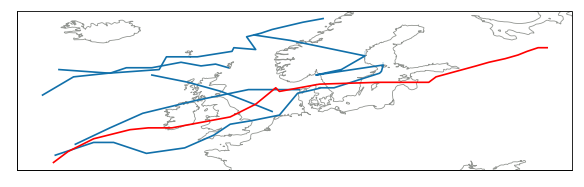

In [28]:
g=sn.relplot(data=ifs_tracks.query('inidate=="2022-02-10" & experiment=="ENS" & number==2'),x='lon',y='lat',size='track_id',sort=False,sizes=(1,1),kind='line',legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())))

sn.lineplot(data=eunice_track,x='lon',y='lat',legend=False,color='r')

g.axes[0,0].coastlines(color='xkcd:grey',lw=0.5)

In [29]:
all_tracks.head()

track_id  year  month  day  hour    i   j   lon    lat       msl        vo  \
0         0  2022      2   14     0  114  62  1.50  58.00  98481.96  0.000082   
1         0  2022      2   14     3  118  61  2.50  58.25  98451.48  0.000102   
2         0  2022      2   14     6  111  70  0.75  56.00  98480.83  0.000113   
3         0  2022      2   14     9  121  68  3.25  56.50  98507.20  0.000095   
4         0  2022      2   14    12  128  65  5.00  57.25  98428.51  0.000175   

  expid experiment    inidate  number                date  
0     1        ENS 2022-02-14       0 2022-02-14 00:00:00  
1     1        ENS 2022-02-14       0 2022-02-14 03:00:00  
2     1        ENS 2022-02-14       0 2022-02-14 06:00:00  
3     1        ENS 2022-02-14       0 2022-02-14 09:00:00  
4     1        ENS 2022-02-14       0 2022-02-14 12:00:00

In [30]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min)).iloc[0]

eunice_filter

date    2022-02-17 09:00:00
day                      26
lon                   -25.5
lat                    47.0
msl                96699.27
Name: (5, 2022-01-01 00:00:00, era5, 0), dtype: object

In [31]:
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]

Very basic selection criteria to start off with here:

In [32]:
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [33]:
ifs_eunice_list.head()

track_id    inidate experiment  number  year  month  day  hour   i    j  \
0         1 2022-02-14        ENS      25  2022      2   17     9   0  111   
1         1 2022-02-14        ENS      25  2022      2   17    12   1  108   
2         1 2022-02-14        ENS      25  2022      2   17    15  10  105   
3         1 2022-02-14        ENS      25  2022      2   17    18  21   99   
4         1 2022-02-14        ENS      25  2022      2   17    21  30   95   

     lon    lat        msl        vo expid                date  
0 -27.00  45.75  100150.40  0.000130     1 2022-02-17 09:00:00  
1 -26.75  46.50   99387.10  0.000238     1 2022-02-17 12:00:00  
2 -24.50  47.25   99108.85  0.000457     1 2022-02-17 15:00:00  
3 -21.75  48.75   98643.55  0.000504     1 2022-02-17 18:00:00  
4 -19.50  49.75   97933.05  0.000611     1 2022-02-17 21:00:00

Secondary filter to ensure each member only has a single track. Select track based on closeness to ERA5 track.

In [34]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

In [35]:
multi_track_members

year
inidate    experiment number      
2022-02-10 ENS        14         2
2022-02-14 incr       9          2
                      28         2
                      41         2
           pi         1          2
                      22         2
2022-02-16 pi         17         2

In [36]:
def eunice_dist(df):
    
    eunice_lons = eunice_track.lon.values
    eunice_lats = eunice_track.lat.values
    
    track_lons = df.lon.values
    track_lats = df.lat.values
    
    minsize = min(eunice_lons.size,track_lons.size)
    
    return np.sqrt((track_lons[:minsize]-eunice_lons[:minsize])**2+(track_lats[:minsize]-eunice_lats[:minsize])**2).sum()

In [37]:
for idx in multi_track_members.index:
    
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(eunice_dist)
    
    num_reject = track_dists.idxmax()
    
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  """Entry point for launching an IPython kernel.


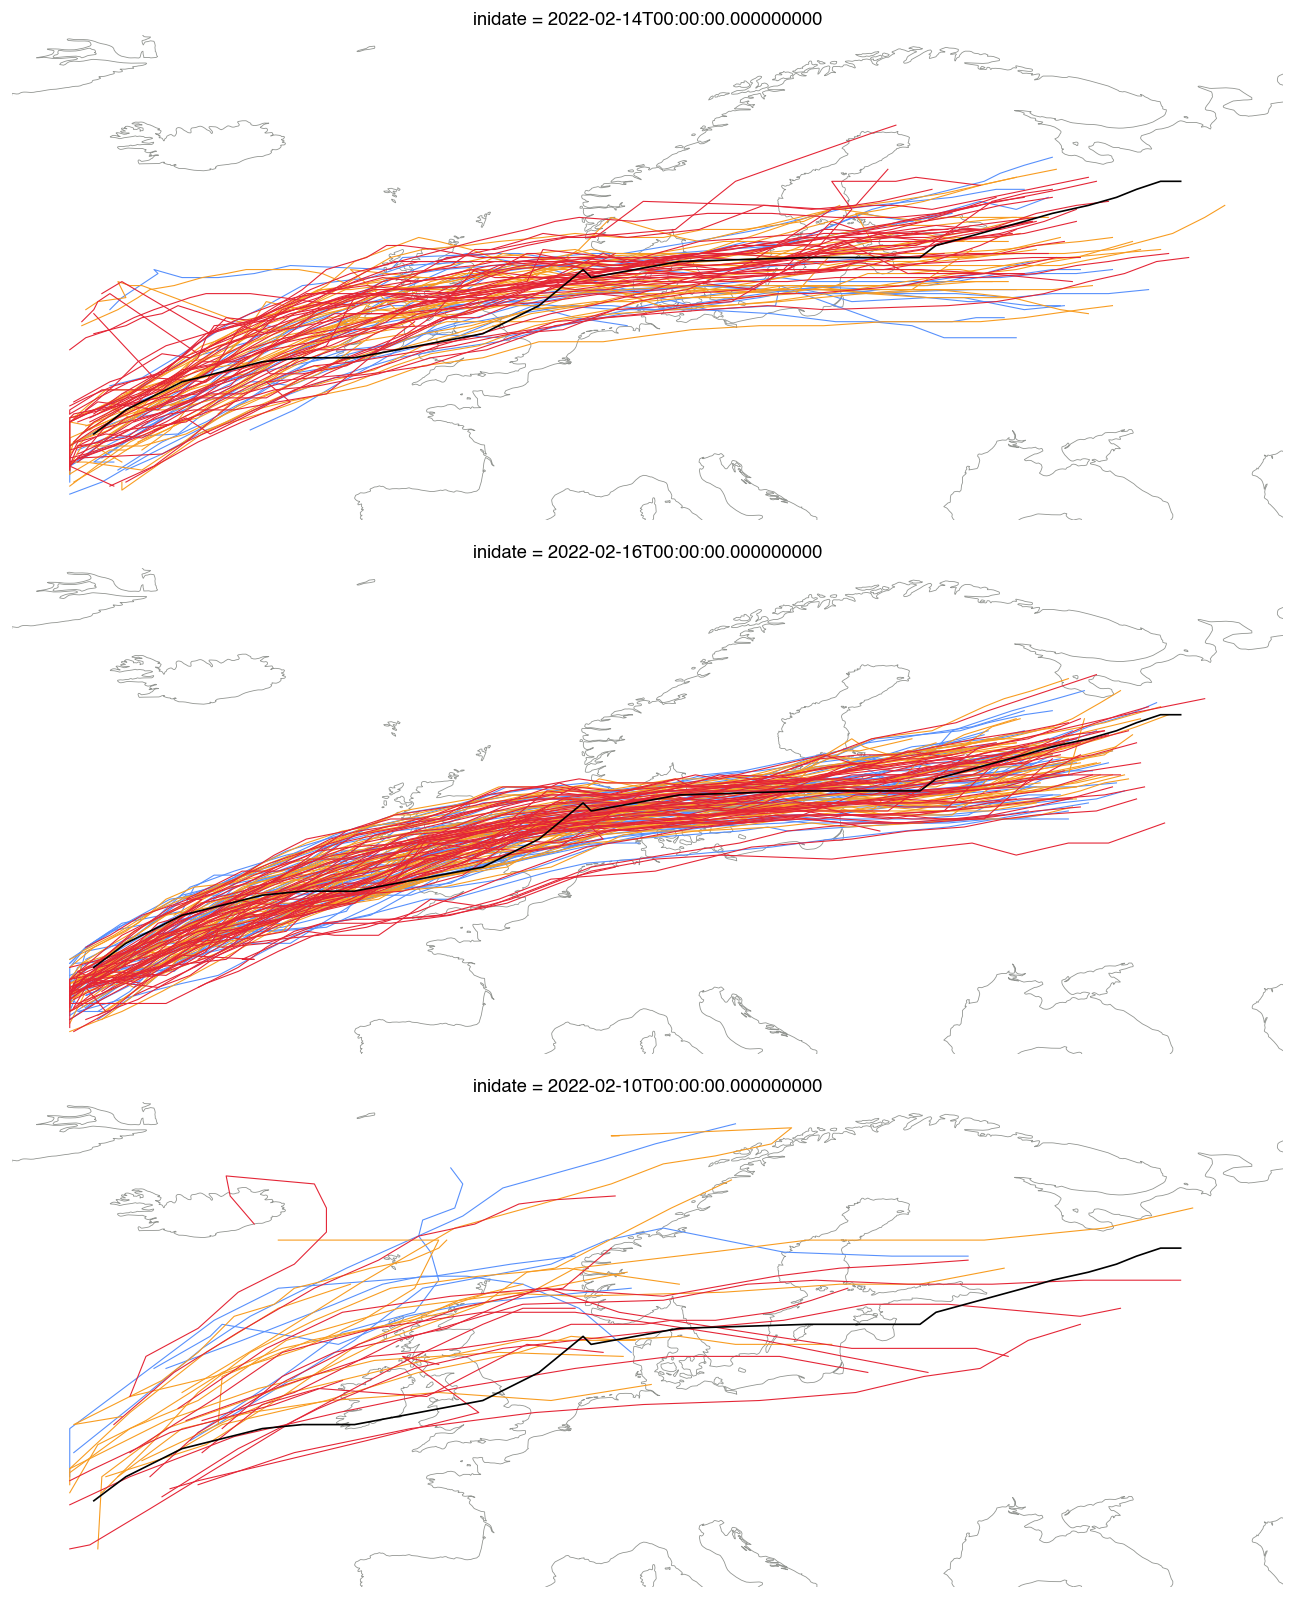

In [38]:
g=sn.relplot(data=ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])],x='lon',y='lat',row='inidate',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),size='number',sort=False,estimator=None,sizes=(0.66,0.66),kind='line',height=4.5,legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())),aspect=3)

[sn.lineplot(data=eunice_track,x='lon',y='lat',legend=False,color='k',ax=a) for a in g.axes.flatten()]
[a.coastlines(color='xkcd:grey',lw=0.5) for a in g.axes.flatten()]
[a.axis('off') for a in g.axes.flatten()];

In [39]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','track_id']).agg(dict(msl=min,date=min,vo=max)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - eunice_filter.date).dt.total_seconds()/(3600*24)

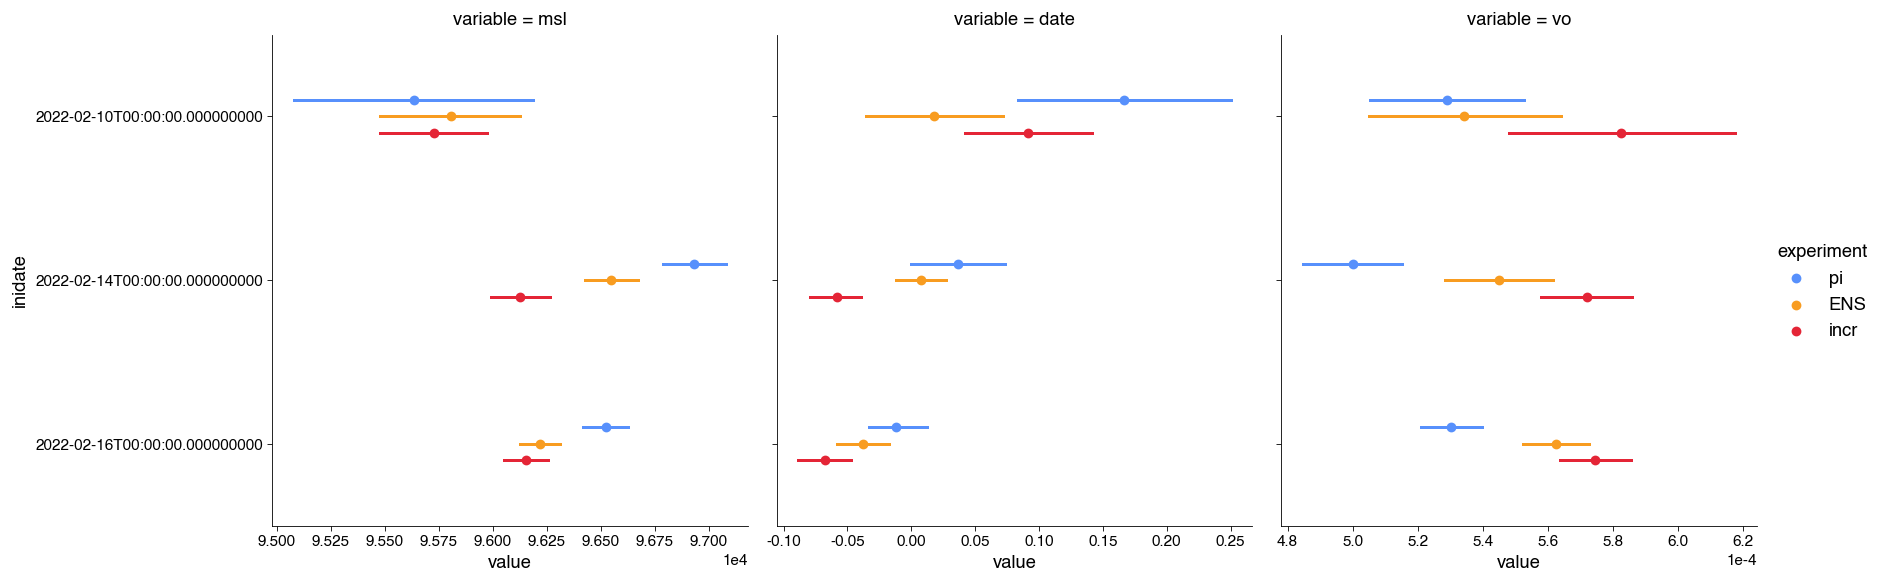

In [67]:
sn.catplot(data=ifs_eunice_list_stats.set_index(['experiment','inidate']).drop(['track_id','number'],axis=1).stack().astype(float).reset_index().rename({'level_2':'variable',0:'value'},axis=1),
           x='value',col='variable',y='inidate',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),kind='point',join=False,dodge=0.2,errorbar=('ci',66),n_boot=10000,sharex=False)

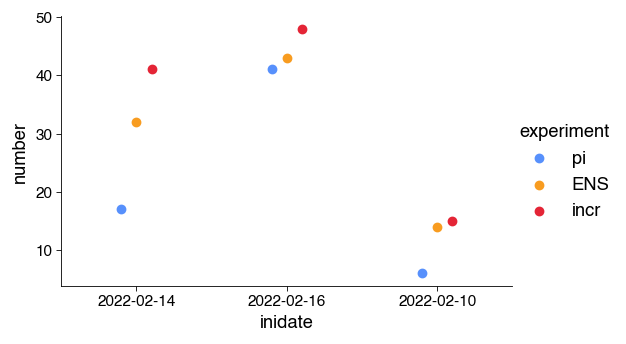

In [41]:
sn.catplot(data=ifs_eunice_list.assign(inidate=lambda x: x.inidate.dt.date),x='inidate',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),y='number',estimator=lambda x: np.unique(x).size,kind='point',dodge=0.2,join=False,height=3,aspect=1.5)

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  


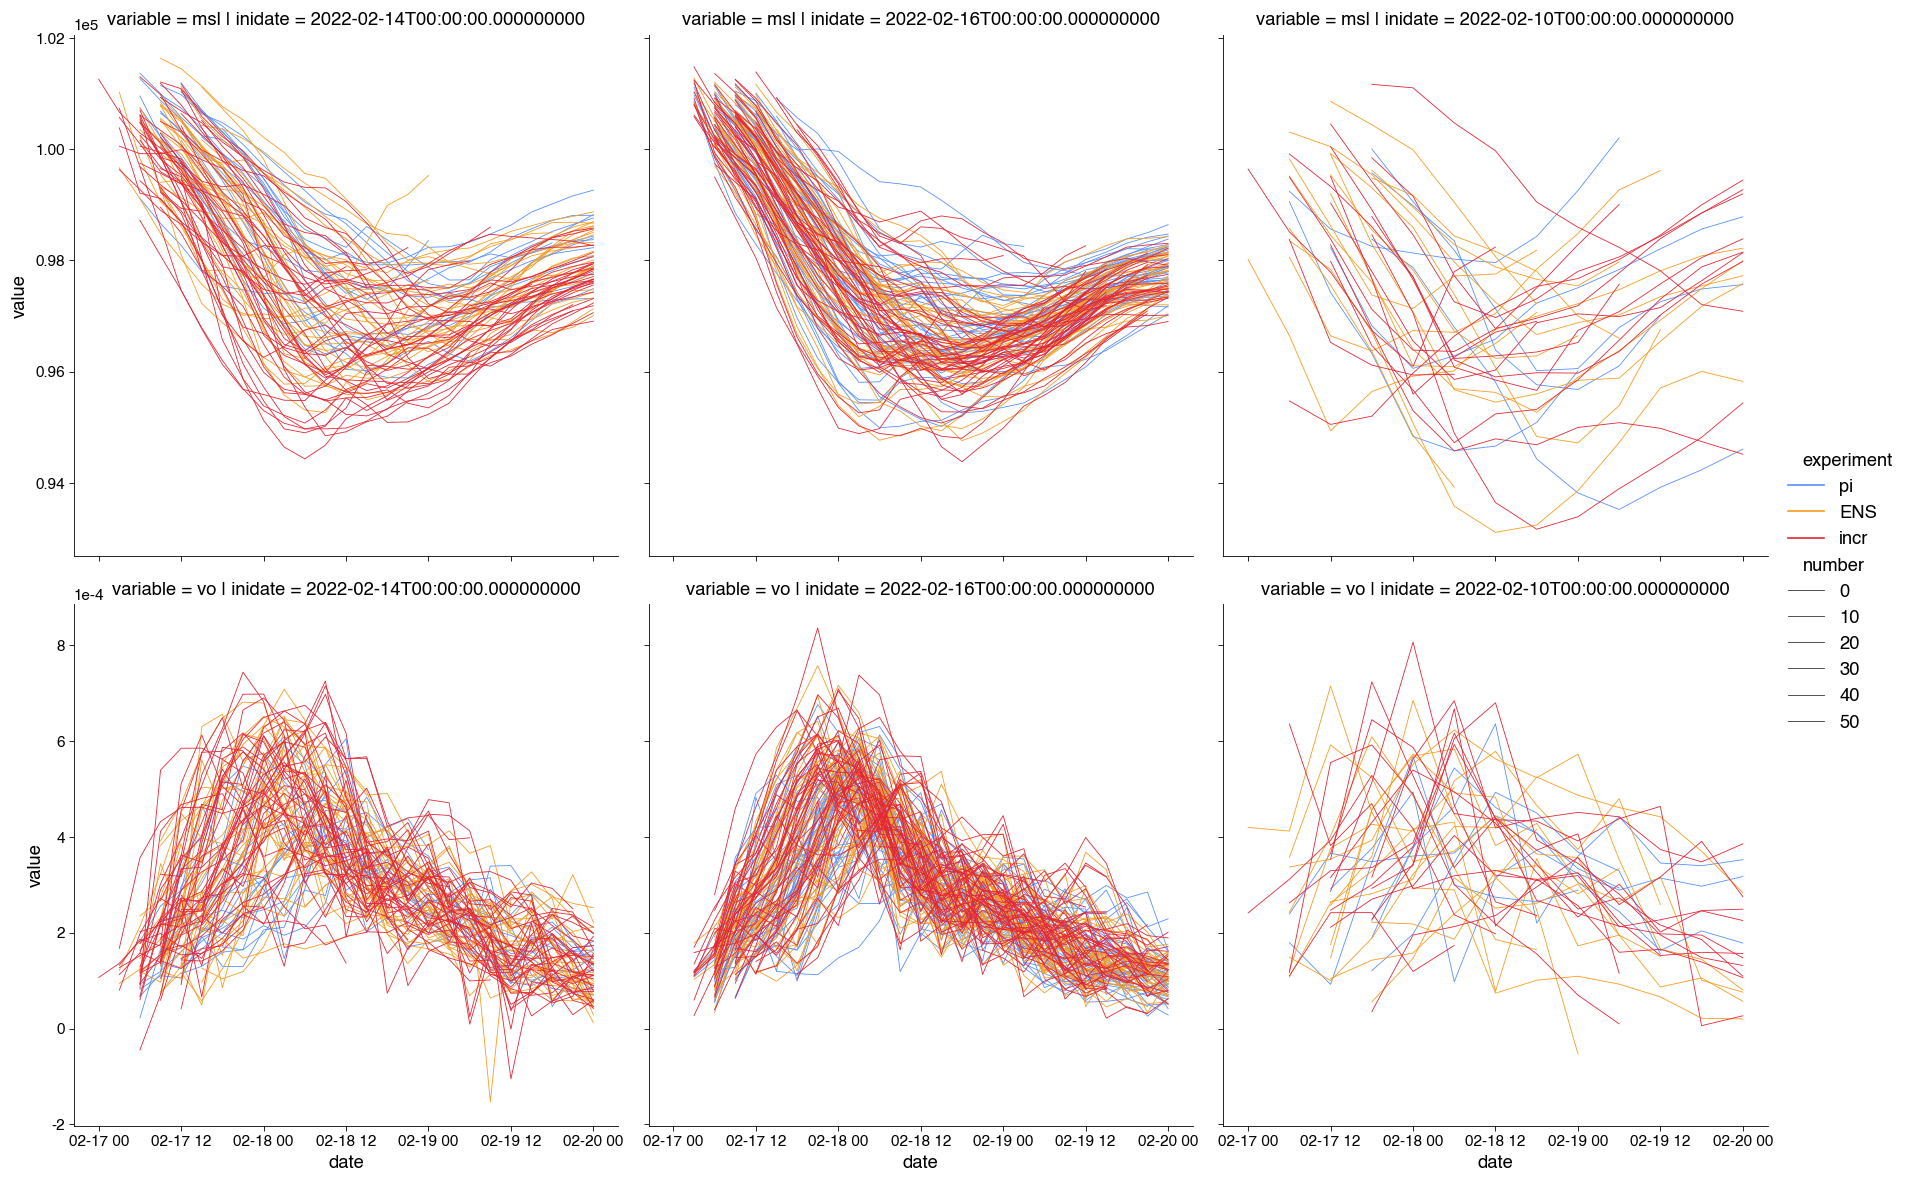

In [42]:
sn.relplot(data=ifs_eunice_list.set_index(['inidate','experiment','number','date']).loc[:,['msl','vo']].stack().reset_index().rename({'level_4':'variable',0:'value'},axis=1),
          x='date',y='value',row='variable',col='inidate',hue_order=['pi','ENS','incr'],hue='experiment',size='number',sizes=(0.5,0.5),estimator=None,sort=False,kind='line',facet_kws=dict(sharey='row'),palette=get_palette.Petroff6().to_sn_palette())

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  


(-27.1375, 36.3875, 44.9625, 67.7875)

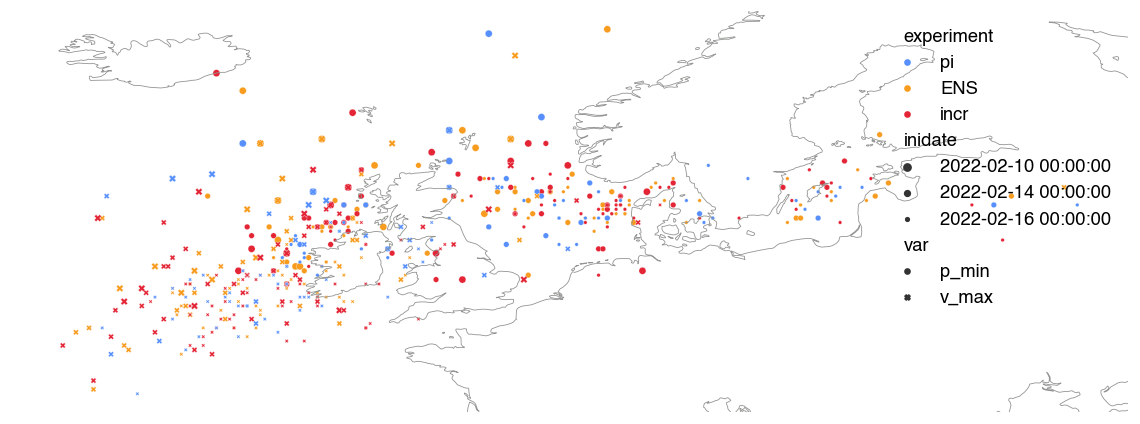

In [43]:
fig,ax = plt.subplots(subplot_kw=dict(projection=crs.PlateCarree()),figsize=(12,5))

g=sn.scatterplot(data=pd.concat([
ifs_eunice_list.groupby(['experiment','inidate','number']).apply(lambda x: x.loc[x.msl.idxmin()])[['msl','lon','lat']].rename({'msl':'value'},axis=1).assign(var='p_min'),
ifs_eunice_list.groupby(['experiment','inidate','number']).apply(lambda x: x.loc[x.vo.idxmax()])[['vo','lon','lat']].rename({'vo':'value'},axis=1).assign(var='v_max'),]).reset_index(),
              x='lon',y='lat',style='var',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),size='inidate',ax=ax)

ax.coastlines(color='xkcd:grey',lw=0.5)

ax.axis('off')

## Bit of Lagrangian frame work

In [44]:
def get_stormframe_fields(track_df):
    
    """
    Return a field centered on the storm mslp minimum from a TE track dataframe.
    
    Relegates time to a variable and indexes by timestep from first detection.
    """
    
    exp = track_df.experiment.unique()[0]
    number = track_df.number.unique()[0]
    inidate = pd.to_datetime(track_df.inidate.unique()[0]).strftime('%Y-%m-%d')
    
    if exp in ['incr','pi']:
        exp = 'EXP/'+exp
    if number == 0:
        ftype = 'cf'
    else:
        ftype = 'pf'
        
    ds_path = glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/{}/EU025/sfc/{}/*_{}.nc'.format(exp,ftype,inidate))[0]
    
    ds = xr.open_dataset(ds_path,chunks=-1)
    if ftype=='pf':
        ds = ds.sel(number=number)
    else:
        ## need to create number dim if control for concat later
        ds = ds.expand_dims({'number':[0]}).sel(number=0)
    time_intersection = sorted(list(set(ds.time.values).intersection(track_df.date.values)))
    ## for longest lead time, need to match the operational ensemble timestep of 6 hours (sort this coding out as it's horrible)
    if inidate == '2022-02-10':
        time_intersection = [x for x in time_intersection if pd.to_datetime(x).hour%6==0]
    ds = ds.sel(time = time_intersection)
    track_df = track_df.loc[track_df.date.isin(time_intersection)]
    ds['centroid_lon'] = ('time',(track_df.lon*4).round()/4)
    ds['centroid_lat'] = ('time',(track_df.lat*4).round()/4)
    
    ds = ds.groupby('time').apply(lagrangian_frame)
    ds = ds.assign(datetime=ds.time).drop('time').rename(time='timestep')
    
    return ds

In [56]:
def preproc_to_stormframe(ds):
    
    ds = ds.copy()
    
    if not 'number' in ds.coords:
        ds = ds.expand_dims({'number':[0]})
        
    fpath = ds.encoding['source']
    
    exp = fpath.split('/')[-5]
    inidate = fpath.split('/')[-1].split('_')[-1].split('.')[0]
    
    ds_tracks = ifs_eunice_list.query('experiment=="{}" & inidate=="{}"'.format(exp,inidate))

    LG_fields = []

    for num in set(ds.number.values).intersection(ds_tracks.number.unique()):

        mem_track = ds_tracks.loc[ds_tracks.number==num]
        mem_fields = ds.sel(number=num)
        time_intersection = sorted(list(set(mem_fields.time.values).intersection(mem_track.date.values)))
        ## resample to 6hrly -> but start at first detection time
        time0_mod = pd.to_datetime(time_intersection[0]).hour%6

        ## get 6hrly indexer for instantaneous fields + start/end time for max since prior preproc step
        time_intersection_6hr = [x for x in time_intersection if pd.to_datetime(x).hour%6==time0_mod]
        time_start = time_intersection_6hr[0]-pd.Timedelta('5h 59m')
        time_end = time_intersection_6hr[-1]

        mem_fields_6hr = mem_fields.get(['sst','u10','v10','msl','u100','v100','tcwv']).sel(time = time_intersection_6hr)
        mem_fields_6hr['ws10'] = np.sqrt(mem_fields_6hr.u10**2+mem_fields_6hr.v10**2)
        mem_fields_6hr['ws100'] = np.sqrt(mem_fields_6hr.u100**2+mem_fields_6hr.v100**2)
        
        mxtpr_field_6hr = mem_fields.mxtpr.sel(time=slice(time_start,time_end)).resample(time='6h',label='right',closed='right',base=time0_mod).max()
        mem_fields_6hr['mxtpr'] = mxtpr_field_6hr

        mem_track_6hr = mem_track.loc[mem_track.date.isin(time_intersection_6hr)]
        mem_fields_6hr['centroid_lon'] = ('time',(mem_track_6hr.lon*4).round()/4)
        mem_fields_6hr['centroid_lat'] = ('time',(mem_track_6hr.lat*4).round()/4)

        mem_fields_6hr = mem_fields_6hr.groupby('time').apply(lagrangian_frame)
        mem_fields_6hr = mem_fields_6hr.assign(datetime=mem_fields_6hr.time).drop('time').rename(time='timestep')

        mem_fields_6hr = mem_fields_6hr.assign_coords(timestep=mem_fields_6hr.timestep)

        LG_fields += [mem_fields_6hr]
        
    LG_fields = xr.concat(LG_fields,'number')
    
    LG_fields = LG_fields.expand_dims(dict(inidate=[pd.to_datetime(inidate)],experiment=[exp]))
    
    return LG_fields
        
        ## these bits are for the max since fields if required (not for now since interpretation a little trickier)...
        
        #     fg10_field_6hr = mem_fields.fg10.sel(time=slice(time_start,time_end)).resample(time='6h',label='right',closed='right',base=time0_mod).max()
            # mxtpr_field_6hr = mem_fields.mxtpr.sel(time=slice(time_start,time_end)).resample(time='6h',label='right',closed='right',base=time0_mod).max()

        #     mem_fields_6hr['fg10'] = fg10_field_6hr
        #     mem_fields_6hr['mxtpr'] = mxtpr_field_6hr


In [57]:
ens_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/co

/home/l/leach/installed-packages/miniconda3/lib/python3.7/contextlib.py:119: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
distributed.worker - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 2.53 GiB -- Worker memory limit: 3.00 GiB
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
distributed.utils - ERROR - Timed out during handshake while connecting to tcp://127.0.0.1:36143 after 30 s
Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7

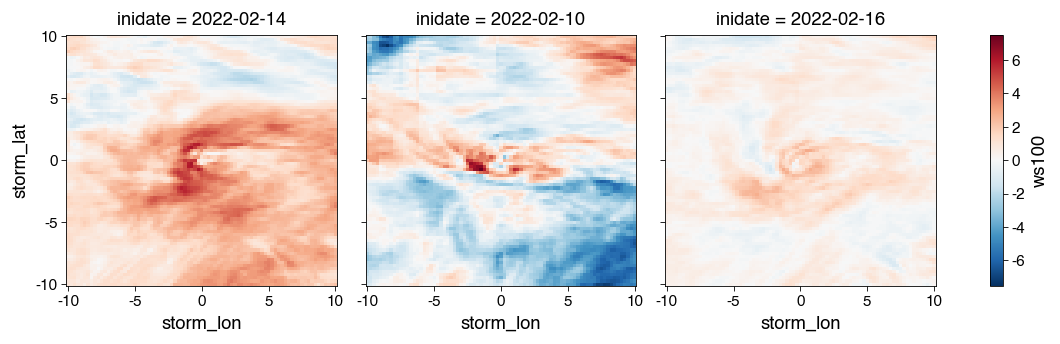

In [47]:
(incr_storms.ws100.sel(timestep=slice(0,7)).max('timestep').mean('number').squeeze() - pi_storms.ws100.sel(timestep=slice(0,7)).max('timestep').mean('number').squeeze()).plot(col='inidate')

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
distributed.worker - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 2.53 GiB -- Worker memory limit: 3.00 GiB
distributed.worker - WARNING - Worker is at 50% memory usage. Resuming worker. Process memory: 1.50 GiB -- Worker memory limit: 3.00 GiB
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
distributed.worker - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 2.56 GiB -- Worker memory

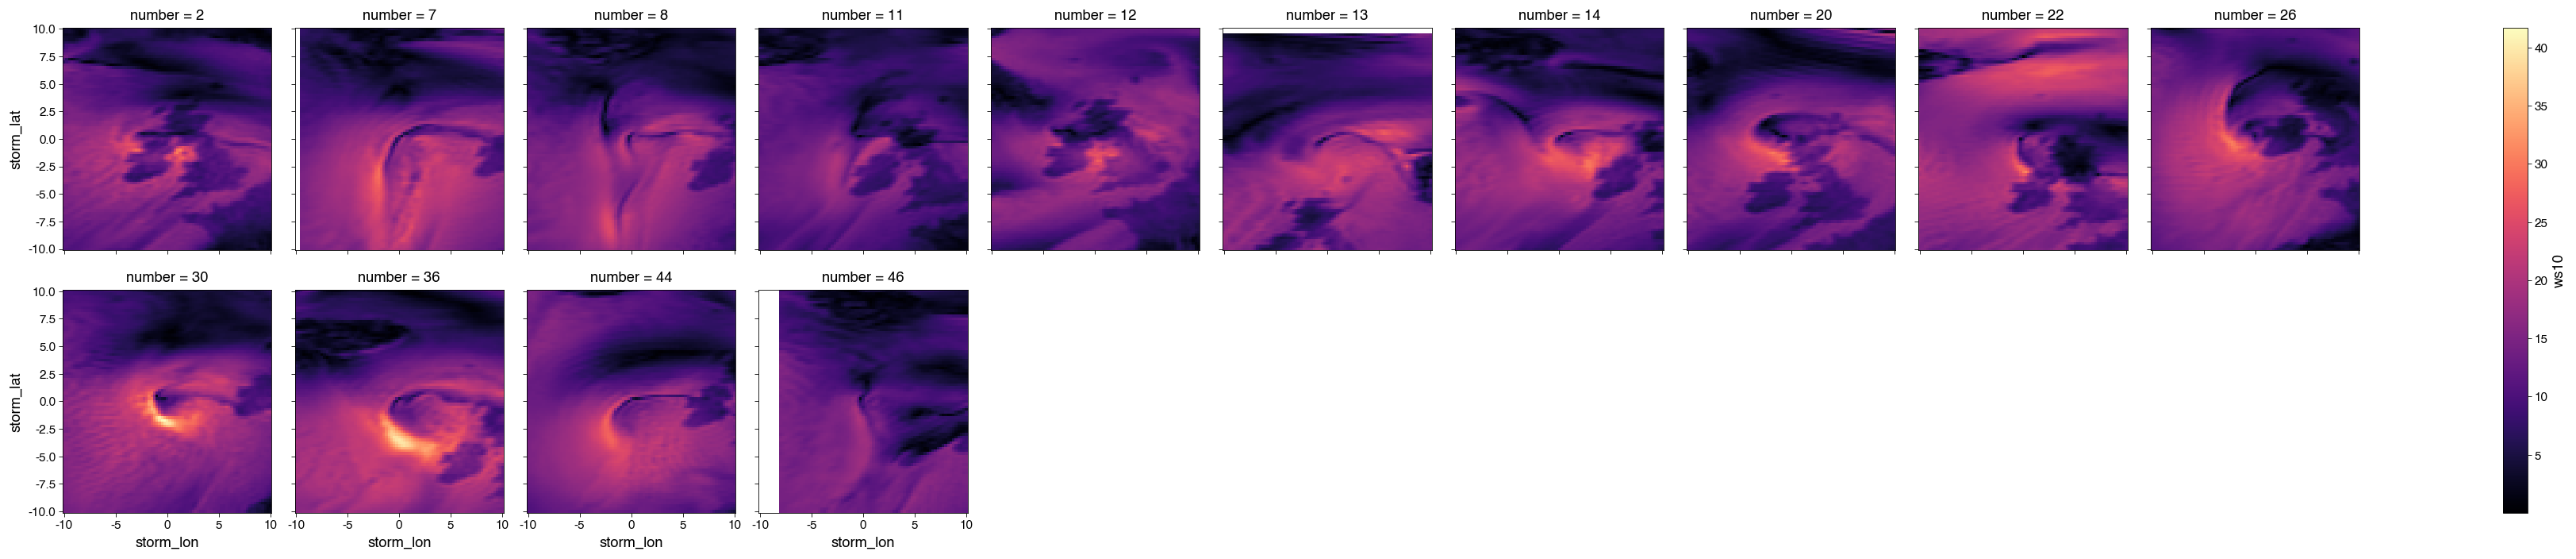

In [48]:
ens_storms.sel(inidate='2022-02-10').isel(timestep=3).ws10.dropna('number',how='all').plot(col='number',col_wrap=10,cmap='magma')

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.41 GiB -- Worker memory limit: 3.00 GiB
distributed.worker - WARNING - Worker is at 49% memory usage. Resuming worker. Process memory: 1.49 GiB -- Worker memory limit: 3.00 GiB
distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.42 GiB -- Worker memory limit: 3.00 GiB
distributed.worker - WARNING - Worker is at 44% memory usage. Resuming worker. Process memory: 1.33 GiB -- Worker memory limit: 3.00 GiB


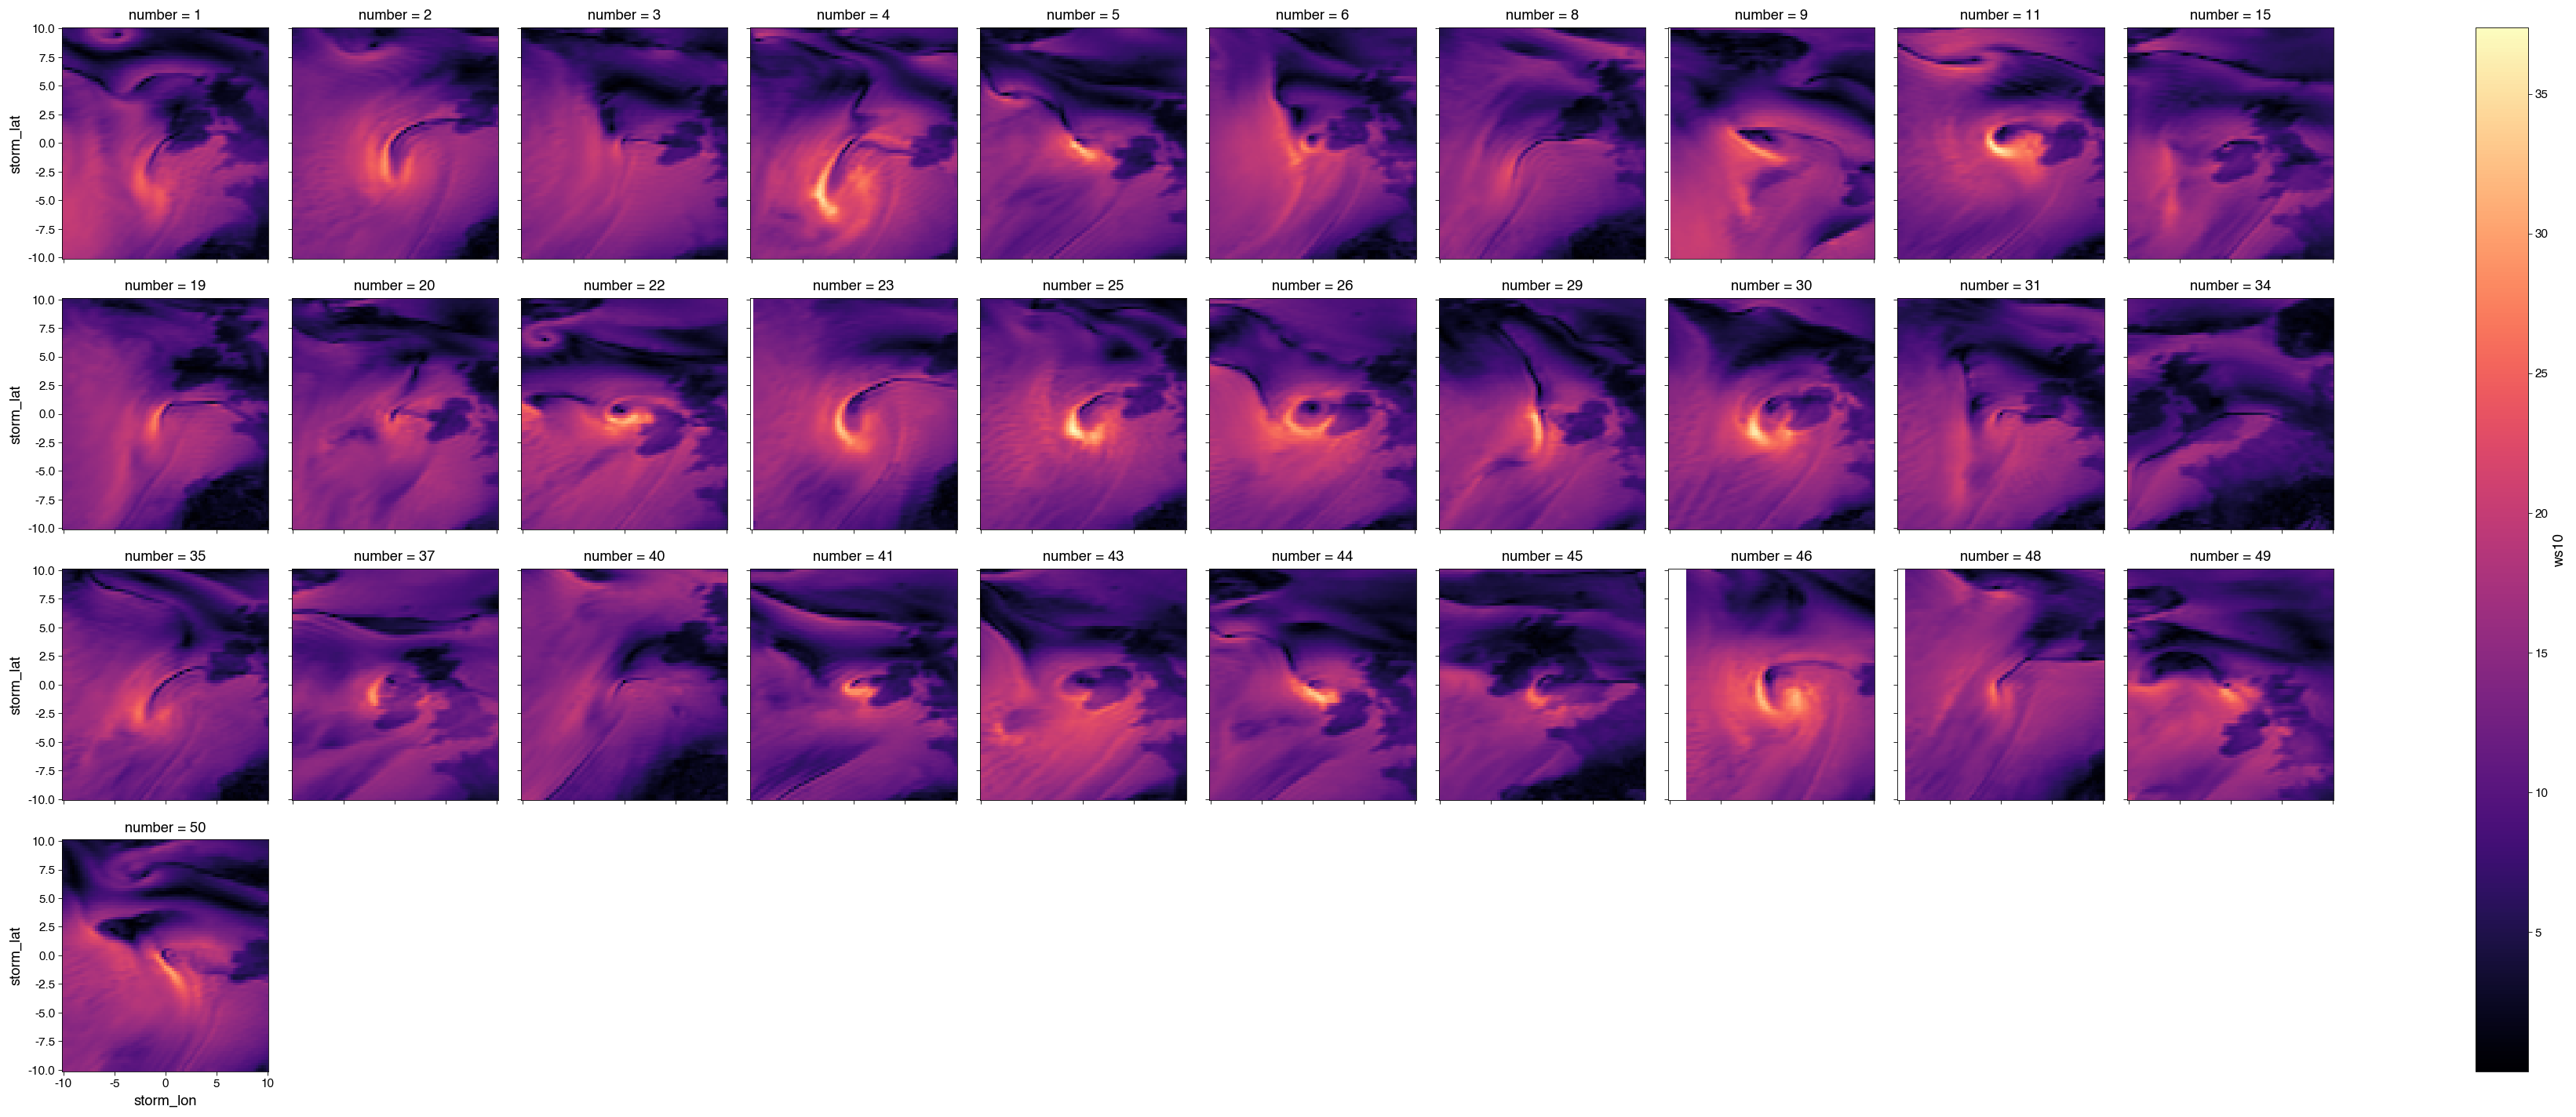

In [49]:
ens_storms.sel(inidate='2022-02-14').isel(timestep=3).ws10.dropna('number',how='all').plot(col='number',col_wrap=10,cmap='magma')

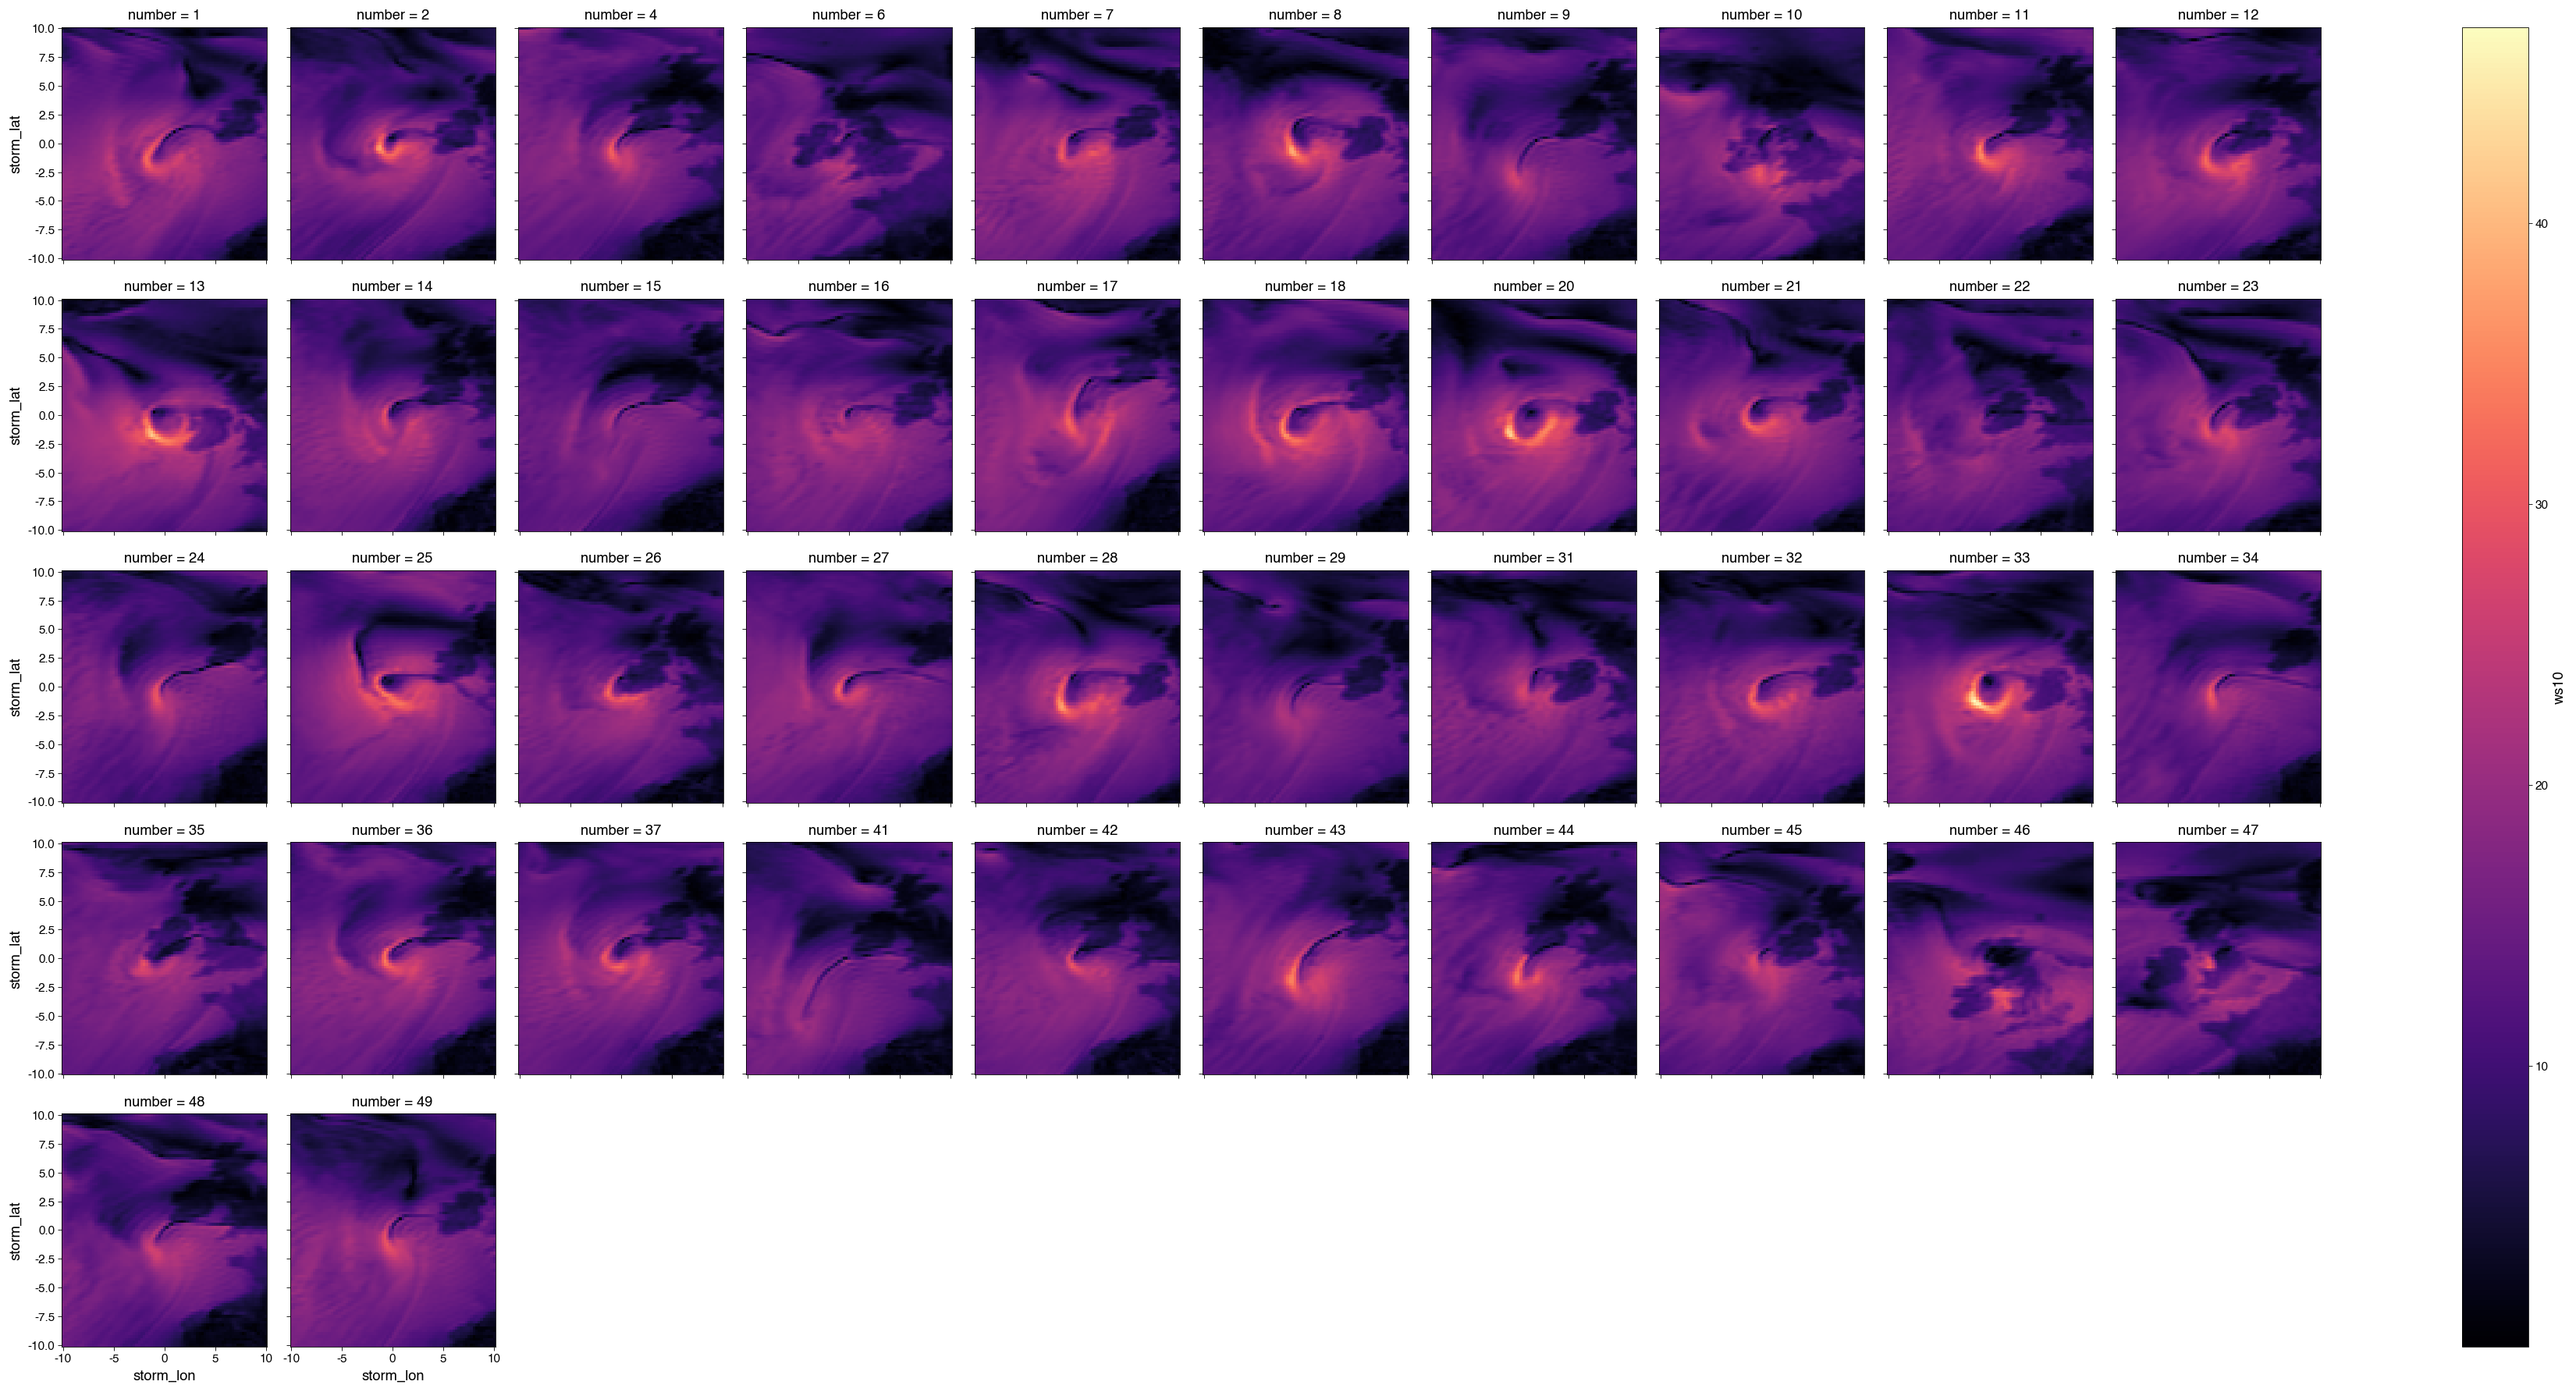

In [50]:
ens_storms.sel(inidate='2022-02-16').isel(timestep=3).ws10.dropna('number',how='all').plot(col='number',col_wrap=10,cmap='magma')

tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x7f17d8386560>, <Task finished coro=<BaseTCPListener._handle_stream() done, defined at /home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py:530> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/tornado/tcpserver.py", line 391, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 536, in _handle_stream
    logger.debug("Incoming connection from %r to %r", address, self.contact_address)
  File "/home/l/leach/install

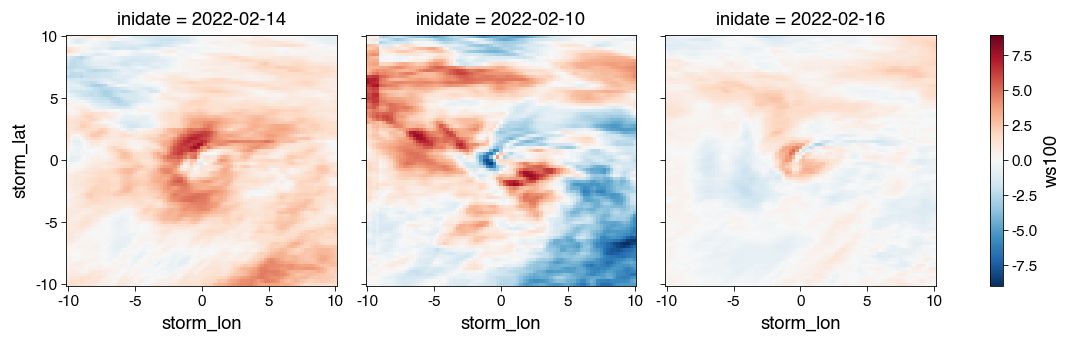

distributed.utils - ERROR - Timed out during handshake while connecting to tcp://127.0.0.1:38939 after 30 s
Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/core.py", line 326, in connect
    handshake = await asyncio.wait_for(comm.read(), time_left())
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/asyncio/tasks.py", line 442, in wait_for
    return fut.result()
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 221, in read
    convert_stream_closed_error(self, e)
  File "/home/l/leach/installed

In [51]:
(incr_storms.ws100.sel(timestep=3).mean('number').squeeze() - pi_storms.ws100.sel(timestep=3).mean('number').squeeze()).plot(col='inidate')

-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 129, in convert_stream_closed_error
    raise CommClosedError(f"in {obj}: {exc}") from exc
distributed.comm.core.CommClosedError: in <TCP (closed)  local=tcp://127.0.0.1:33828 remote=tcp://127.0.0.1:38939>: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/utils.py", line 693, in log_errors
    yield
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/worker.py", line 1617, in close
    await r.close_gracefully()
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/core.py", line 902, in send_recv_from_rpc
    comm = await self.pool.connect(self.addr)
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/core.py", line 1072, in co

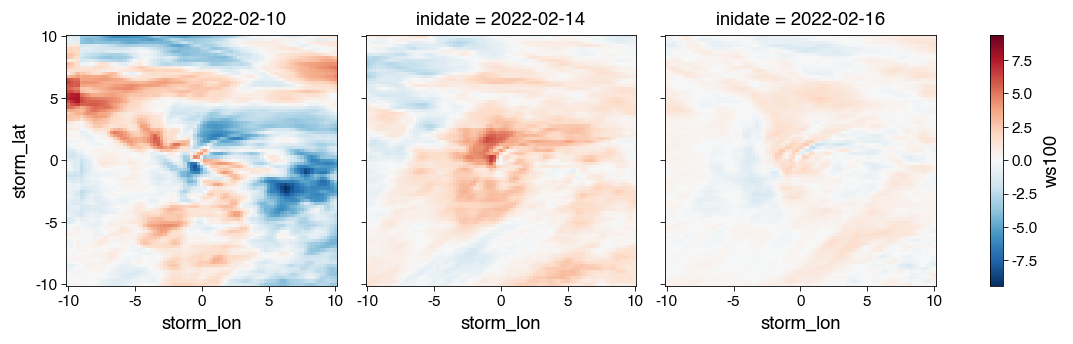

In [52]:
(ens_storms.ws100.sel(timestep=3).mean('number').squeeze() - pi_storms.ws100.sel(timestep=3).mean('number').squeeze()).plot(col='inidate')

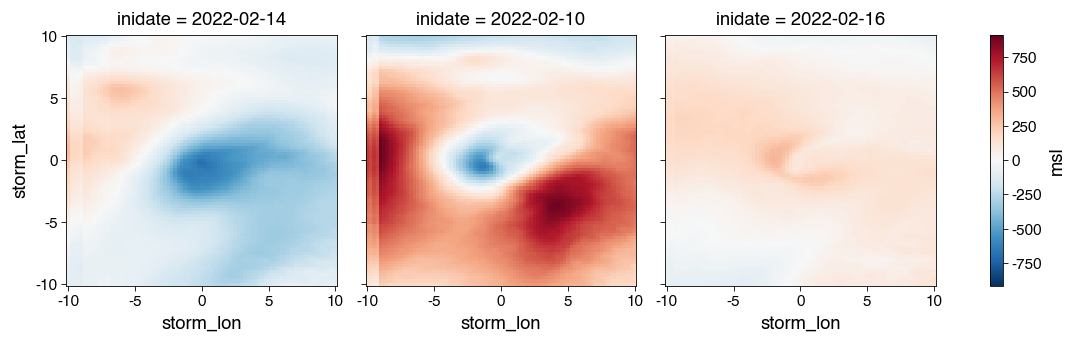

distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing


In [53]:
(incr_storms.msl.sel(timestep=3).mean('number').squeeze() - pi_storms.msl.sel(timestep=3).mean('number').squeeze()).plot(col='inidate')

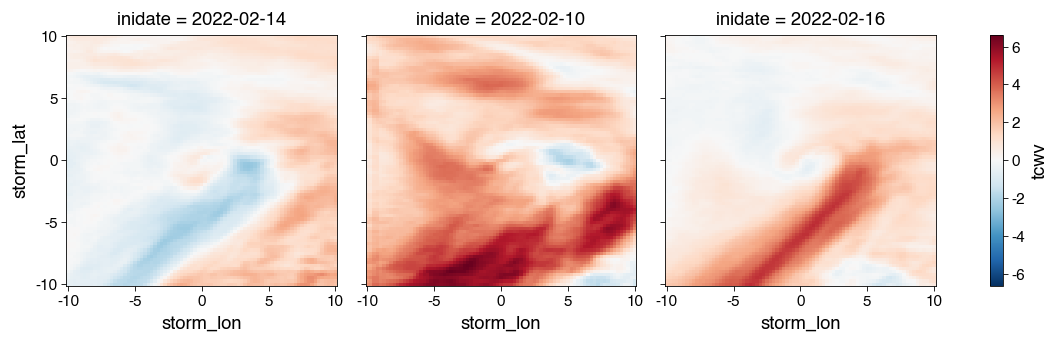

In [58]:
(incr_storms.tcwv.sel(timestep=3).mean('number').squeeze() - pi_storms.tcwv.sel(timestep=3).mean('number').squeeze()).plot(col='inidate')

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fcfdc291bd0>>, <Task finished coro=<Worker.close() done, defined at /home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/worker.py:1593> exception=CommClosedError('in <TCP (closed) ConnectionPool.close_gracefully local=tcp://127.0.0.1:43908 remote=tcp://127.0.0.1:44411>: Stream is closed')>)
Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/hom

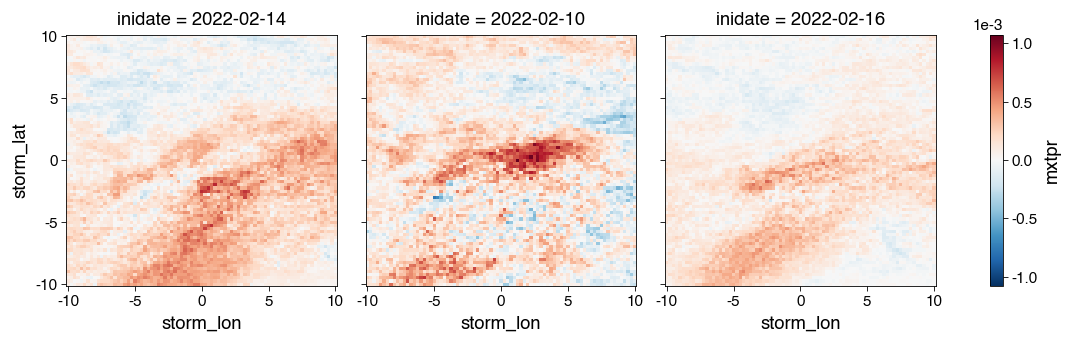

tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x7f1543695950>, <Task finished coro=<BaseTCPListener._handle_stream() done, defined at /home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py:530> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/tornado/tcpserver.py", line 391, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 536, in _handle_stream
    logger.debug("Incoming connection from %r to %r", address, self.contact_address)
  File "/home/l/leach/install

In [69]:
(incr_storms.mxtpr.sel(timestep=slice(0,7)).max('timestep').mean('number').squeeze() - pi_storms.mxtpr.sel(timestep=slice(0,7)).max('timestep').mean('number').squeeze()).plot(col='inidate')

## Some plots by timestep

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fb537800110>>, <Task finished coro=<Worker.close() done, defined at /home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/worker.py:1593> exception=CommClosedError('in <TCP (closed) ConnectionPool.close_gracefully local=tcp://127.0.0.1:59984 remote=tcp://127.0.0.1:35031>: Stream is closed')>)
Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret =

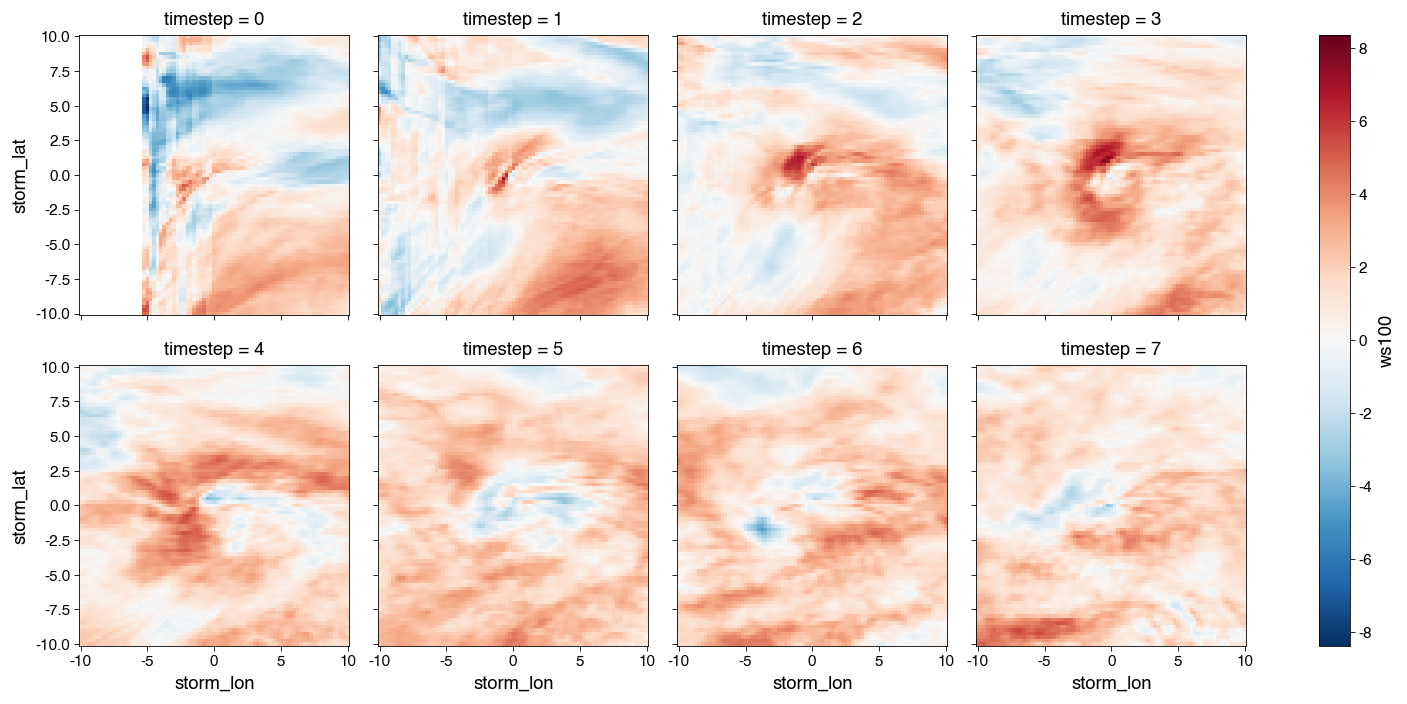

distributed.nanny - WARNING - Worker process still alive after 3.999998664855957 seconds, killing


In [62]:
(incr_storms.ws100.sel(inidate='2022-02-14',timestep=slice(0,7)).mean('number').squeeze() - pi_storms.ws100.sel(inidate='2022-02-14',timestep=slice(0,7)).mean('number').squeeze()).plot(col='timestep',col_wrap=4)

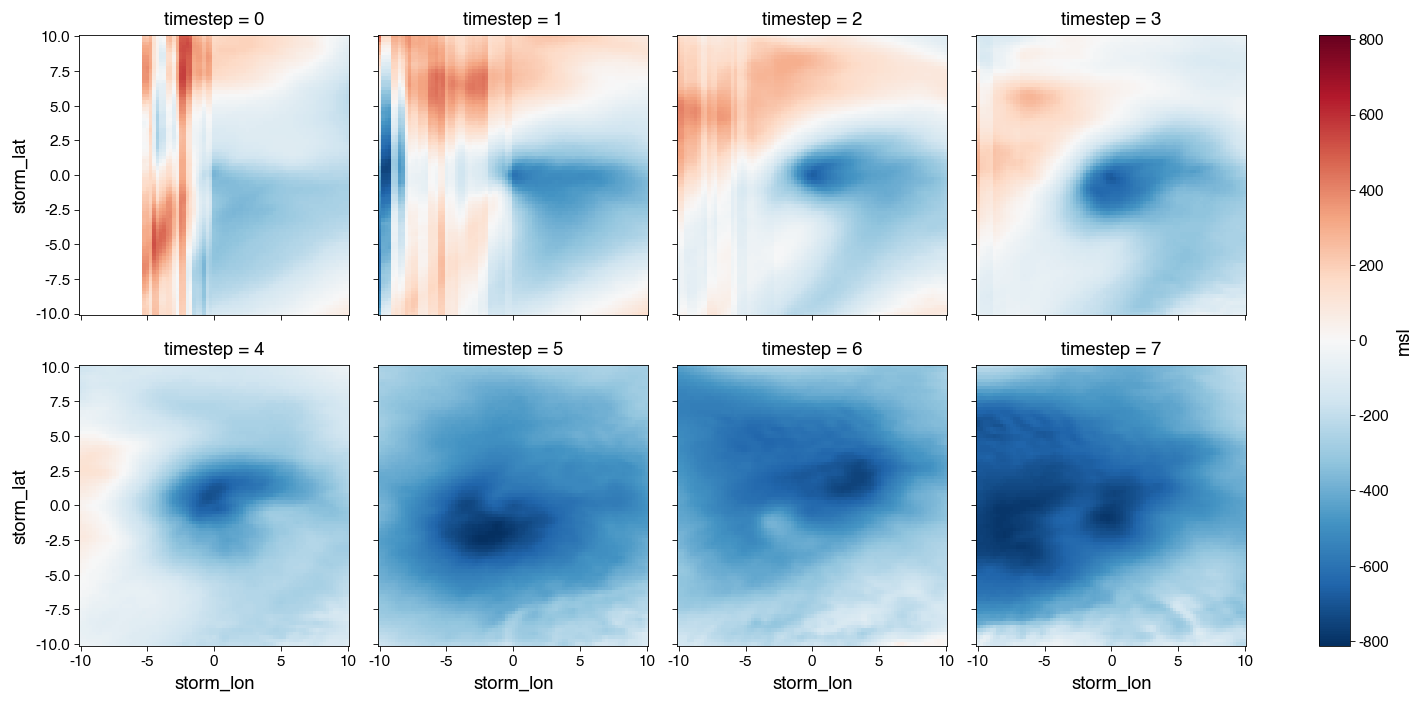

In [63]:
(incr_storms.msl.sel(inidate='2022-02-14',timestep=slice(0,7)).mean('number').squeeze() - pi_storms.msl.sel(inidate='2022-02-14',timestep=slice(0,7)).mean('number').squeeze()).plot(col='timestep',col_wrap=4)

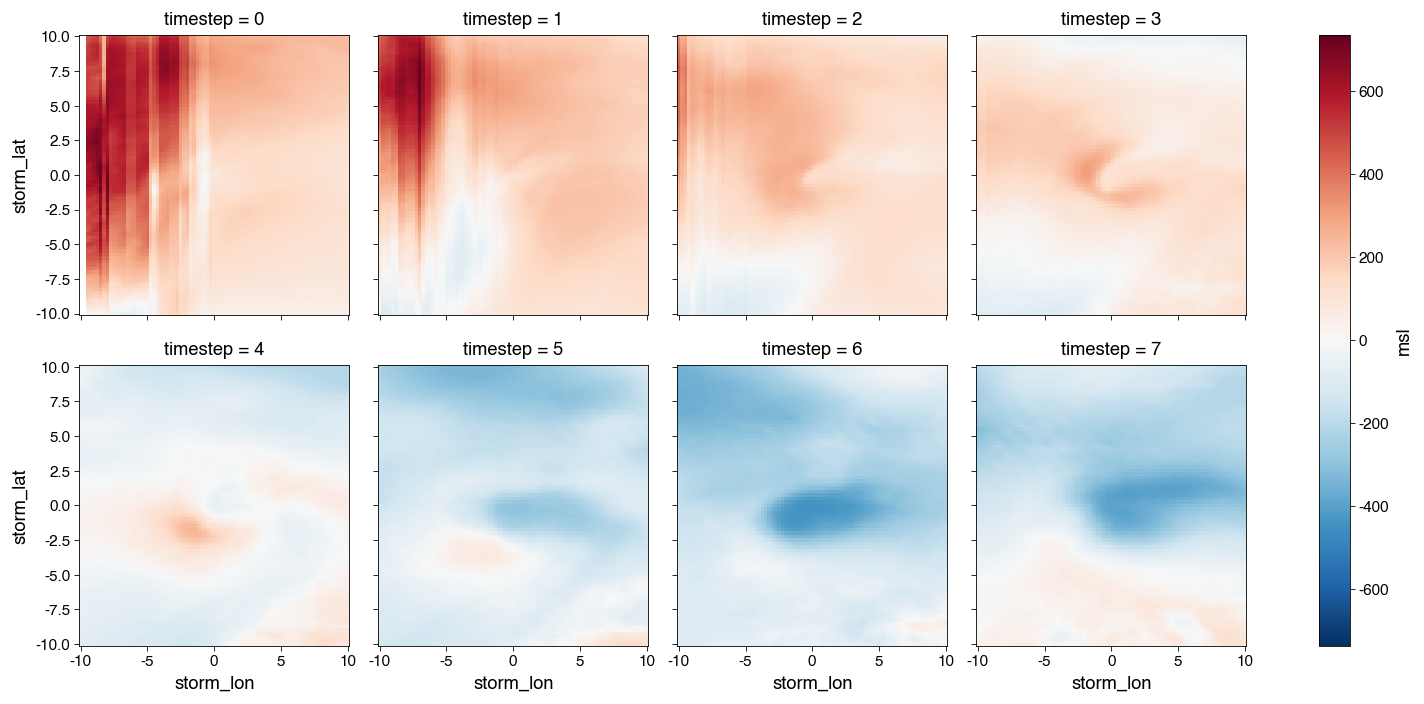

In [64]:
(incr_storms.msl.sel(inidate='2022-02-16',timestep=slice(0,7)).mean('number').squeeze() - pi_storms.msl.sel(inidate='2022-02-16',timestep=slice(0,7)).mean('number').squeeze()).plot(col='timestep',col_wrap=4)

## Some thoughts:
- Wind speed strengthening with CC appears fairly robust over the two shortest leads.
- Increased number of Eunice-like tracks with CC (nb. bias in longest lead detection since operational forecast is based on 6hrly data)
- pi tracks in logest lead appear to have slight Northwards shift -> may explain the less clear picture wrt. intensity?
    - This Northward shift also messes with assessing how CC affects the deepening of the cyclone -> need to account for the background state?
- Looks like a CC may have very slightly affected min central pressure -> doubt statistically significant.
- From the *sprinkle* plot looks like CC may have resulted in more rapid intensification (peak vort) in mid lead.